<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 2 - Aplicaciones Recientes de Redes Neuronales </H3>
<hr style="height:2px;border:none"/>

<H3 align='center'> Fernanda Urrea, ROL: 201551522-0</H3>
<H3 align='center'>Matías Gómez, ROL: 201460501-3</H3>

## 1. RNN sobre texto

Hoy en dı́a, una aplicación relevante de las redes neuronales recurrentes es el modelamiento de texto y lenguaje natural. En esta sección abordaremos el problema de procesar sentencias de texto, proporcionadas por GMB (*Groningen Meaning Bank*), para reconocimiento de entidades y *tagger*. En específico, trabajaremos con el dataset proprocionado a través de __[Kaggle](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus)__, que está compuesto por más de un millón de palabras, a fin de realizar predicciones sobre distintas tareas de redes recurrentes.

<img src="https://i.stack.imgur.com/b4sus.jpg" width="70%" />


Descargue los datos de la página de __[Kaggle](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus)__ y cárguelos mediante *pandas*.

In [1]:
import numpy as np
import pandas as pd
df_ner = pd.read_csv("/Users/Fernanda/Documents/Redes neuronales/tarea2/entity-annotated-corpus/ner.csv", encoding ="cp1252", error_bad_lines=False)
df_ner.dropna(inplace=True)

In [2]:
df_ner.head()

,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,...,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,...,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,...,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,...,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


In [7]:
print("EL DataFrame contiene ",len(df_ner)," ejemplos")

EL DataFrame contiene  1048573  ejemplos


Se utilizan las etiquetas Start y End para referirse al inicio y término de una oración. 

Para el procesamiento natural de texto un token se define como un string de caracteres contiguos entre dos espacios o entre un space y simbolos de puntuación, un token podría no necesariamente ser una palabra sino que tambien podría ser un numero.
Otra definición importante dentro del procesamiento de texto es lema que corresponde a la forma canónica de una palabra, es decir tal cual podría aparecer en el diccionario.  
Dicho esto se explica a continuación las columnas del dataset, según la documentación de origen:  
**lemma**:Lemma of a token in sentence    
**next-lemma**:Lemma of next token in sentence  
**next-next-lemma**:Lemma of token at +2nd position to the current token in sentence  
**next-next-pos**:POS tag of token at +2nd position to the current token in sentence  
**next-next-shape**:Shape of token at +2nd position to the current token in sentence  
**next-next-word**:Token at +2nd position to the current token in sentence  
**next-pos**:POS tag of the next(+1 position) token  
**next-shape**:Shape of the next(+1 position) token  
**next-word**:Next(+1 position) token  
**pos**:POS tag of current token  
**prev-iob**:IOB annotation of previous token  (Inside–outside–beginning)  
**prev-lemma**:Lemma of previous token  
**prev-pos**:POS tag for previous token  
**prev-prev-iob**:IOB annotation of token at -2nd position to the current token in sentence  
**prev-prev-lemma**:Lemma of token at -2nd position to the current token in sentence  
**prev-prev-pos**:POS tag of token at -2nd position to the current token in sentence  
**prev-prev-shape**:Shape of token at -2nd position to the current token in sentence  
**prev-prev-word**:Token at -2nd position to the current token in sentence  
**prev-shape**:Shape of previous(-1 position to current token) token  
**prev-word**:Previous word(-1 position to current token)  
**sentence_idx**:Sentence Index(Tokens having same index belongs to same sentence)  
**shape**:Shape of the token in sentence  
**word**:Often termed as Token  
**tag**:IOB annotation of current token

### a) En esta primera instancia trabajaremos con la tarea de realizar un NER *tag* (**Named Entity Recognition**) sobre cada una de las palabras en las sentencias que se nos presenta en los datos. Esta tarea es del tipo *many to many*, es decir, la entrada es una secuencia y la salida es una secuencia, sin *shift*, por lo que necesitaremos una estructura de red adecuada a ésto. En primer lugar extraiga las columnas que utilizaremos del dataset **¿Por qué es conveniente utilizar *lemma* en vez de la misma palabra?**

Se detallan y se extraen las columnas que se utilizarán para el dataset:

In [2]:
dataset = df_ner.loc[:,["lemma","word","pos","tag","prev-iob"]]

In [9]:
dataset.head()

,lemma,word,pos,tag,prev-iob
0,thousand,Thousands,NNS,O,__START1__
1,of,of,IN,O,O
2,demonstr,demonstrators,NNS,O,O
3,have,have,VBP,O,O
4,march,marched,VBN,O,O


El lemma, a diferencia de la palabra completa, se refiere a solo la raiz de la palabra (significado semántico de la palabra). De ahí que es importante utilizar el lemma en vez de la misma palabra pues para una misma raiz, existen muchas posibles palabras asociadas y como se va a trabajar con redes neuronales, se busca que la red pueda aprender y evitar el overfitting que puede haber al reconocer palabras distintas procedentes de un mismo lemma como clases diferentes.

### Luego de esto cree una estructura que contendrá todas las sentencias u oraciones (lista de *lemmas*) y otra estructura que contendrá las etiquetas (lista de *tags*). **¿Cuales son las dimensiones?¿Cada dato de ejemplo tiene las mismas dimensiones que el resto?**

In [3]:
n_used = 500000 #data to use-- your choice
dataX_raw,dataY_raw = [],[]
lemmas,labels = set(), set()  #uniques
sentence=[];
labels_sentence=[];
for fila in dataset.values[:n_used]:
    if fila[-1]=="__START1__": 
        dataX_raw.append(sentence)
        dataY_raw.append(labels_sentence)
        sentence= []
        labels_sentence = []
    lemmas.add(fila[0])
    labels.add(fila[3])
    sentence.append(fila[0]) #add lemma
    labels_sentence.append(fila[3]) #TAG
dataX_raw = dataX_raw[1:]
dataY_raw = dataY_raw[1:]

Se muestran detalles de **dataX_raw**, que es la estructura que contendrá todas las sentencias u oraciones.

In [11]:
dataX_raw

[['thousand',
  'of',
  'demonstr',
  'have',
  'march',
  'through',
  'london',
  'to',
  'protest',
  'the',
  'war',
  'in',
  'iraq',
  'and',
  'demand',
  'the',
  'withdraw',
  'of',
  'british',
  'troop',
  'from',
  'that',
  'countri',
  '.'],
 ['famili',
  'of',
  'soldier',
  'kill',
  'in',
  'the',
  'conflict',
  'join',
  'the',
  'protest',
  'who',
  'carri',
  'banner',
  'with',
  'such',
  'slogan',
  'as',
  '"',
  'bush',
  'number',
  'one',
  'terrorist',
  '"',
  'and',
  '"',
  'stop',
  'the',
  'bomb',
  '.',
  '"'],
 ['they',
  'march',
  'from',
  'the',
  'hous',
  'of',
  'parliament',
  'to',
  'a',
  'ralli',
  'in',
  'hyde',
  'park',
  '.'],
 ['polic',
  'put',
  'the',
  'number',
  'of',
  'marcher',
  'at',
  '10,000',
  'while',
  'organ',
  'claim',
  'it',
  'was',
  '1,00,000',
  '.'],
 ['the',
  'protest',
  'come',
  'on',
  'the',
  'eve',
  'of',
  'the',
  'annual',
  'confer',
  'of',
  'britain',
  "'s",
  'rule',
  'labor',
  'part

In [7]:
len(dataX_raw)

22901

In [32]:
for i in range(10):
    print(len(dataX_raw[i]))

24
30
14
15
25
24
21
28
15
25


Hay 22901 oraciones cada una de largos variables como se ve en la impresión anterior.

Se muestran detalles de **dataY_raw**, que es la estructura que contendrá toddos los tag.

In [12]:
dataY_raw

[['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-geo',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-geo',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-gpe',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-per',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-geo',
  'I-geo',
  'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-geo',
  'O',
  'O',
  'B-org',
  'I-org',
  'O',
  'O',
  'O',
  'B-gpe',
  'O',
  'O',
  'O',
  'B-geo',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'B-gpe',
  'O',
  'O',
  'O',
  'O',
  'B-geo',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-gpe',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'B-geo',
  'O',
  'O',
  'O',
  '

In [33]:
len(dataY_raw)

22901

In [34]:
for i in range(10):
    print(len(dataY_raw[i]))

24
30
14
15
25
24
21
28
15
25


dataY_raw tiene la misma cantidad de datos que dataX_raw

### b) Estudie la distribución del largo de los textos a procesar. Estudie también la frecuencia con la que aparecen las palabras en todo el dataset. **¿Se observa una ley Zipf?**[[1]](#refs) Realice un gráfico de la cantidad de datos por clase. Comente.

In [4]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.mlab as mlab
import pandas as pd
from pandas import Series
from collections import Counter
from scipy import special
import tensorflow as tf

In [9]:
list_len_text=[]
n_max=len(dataX_raw)
for i in range(n_max):
    list_len_text.append(len(dataX_raw[i]))

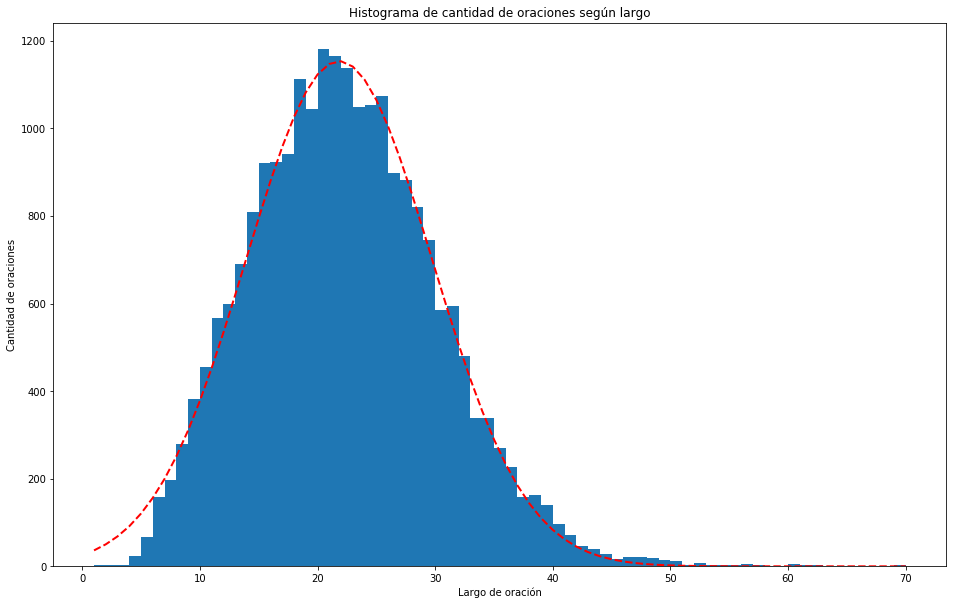

In [37]:
plt.figure(figsize=(16,10))
plt.title('Histograma de cantidad de oraciones según largo')
plt.ylabel('Cantidad de oraciones')
plt.xlabel('Largo de oración')
(mu, sigma) = norm.fit(list_len_text)
bins=range(min(list_len_text), max(list_len_text) + 1,1)
y = norm.pdf( bins,mu, sigma)
l = plt.plot(bins, y*22901, 'r--', linewidth=2)
plt.hist(list_len_text, bins=range(min(list_len_text), max(list_len_text) + 1,1));

Notamos que la cantidad de oraciones según su largo se comporta como una distribución normal como se ve anteriormente.

In [51]:
lista_palabras=[]
largo=len(dataset.values[:n_used])
for i in range(largo):
    lista_palabras.append(dataset.values[i][0])

In [64]:
len(lista_palabras)

500000

In [82]:
Counter(lista_palabras).most_common()

[('the', 30585),
 ('.', 22825),
 (',', 15448),
 ('in', 13241),
 ('of', 12453),
 ('to', 11250),
 ('a', 11073),
 ('and', 9638),
 ("'s", 5150),
 ('say', 4634),
 ('for', 4177),
 ('on', 3427),
 ('has', 3385),
 ('is', 3288),
 ('that', 3049),
 ('it', 2982),
 ('have', 2640),
 ('with', 2607),
 ('said', 2528),
 ('was', 2393),
 ('at', 2225),
 ('from', 2202),
 ('he', 2133),
 ('by', 2124),
 ('an', 2046),
 ('as', 1997),
 ('offici', 1968),
 ('u.s.', 1902),
 ('kill', 1839),
 ('are', 1809),
 ('were', 1671),
 ('will', 1656),
 ('"', 1648),
 ('presid', 1626),
 ('his', 1606),
 ('mr.', 1492),
 ('govern', 1470),
 ('be', 1452),
 ('been', 1401),
 ('two', 1372),
 ('peopl', 1368),
 ('after', 1363),
 ('state', 1354),
 ('not', 1337),
 ('countri', 1334),
 ('report', 1283),
 ('attack', 1218),
 ('but', 1183),
 ('they', 1169),
 ('year', 1127),
 ('also', 1116),
 ('more', 1079),
 ('nation', 1072),
 ('unit', 1060),
 ('other', 1016),
 ('minist', 976),
 ('new', 953),
 ('militari', 953),
 ('who', 918),
 ('group', 906),
 ('t

Text(0, 0.5, 'frequency')

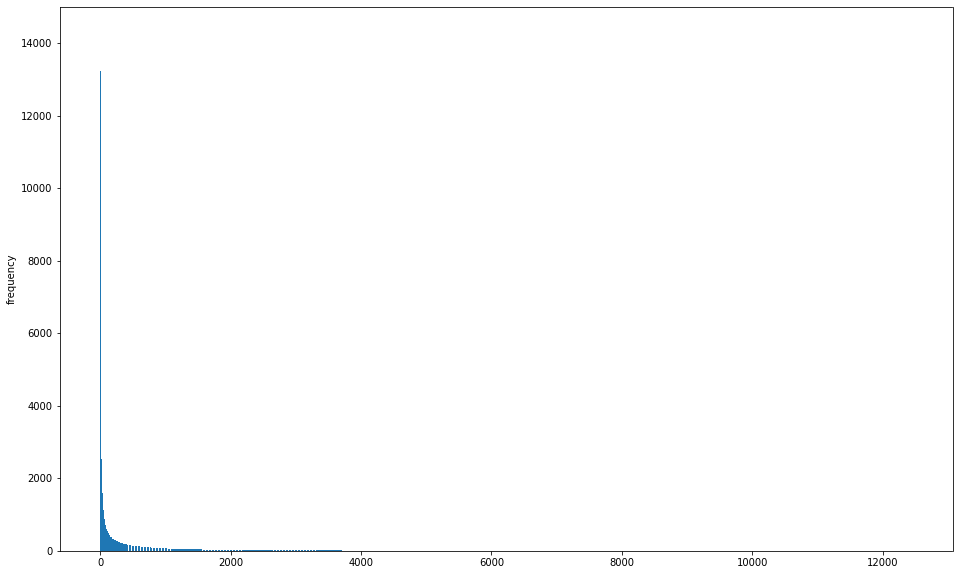

In [152]:
frequency=dict(Counter(lista_palabras).most_common())
x=list(frequency.values())
max=len(x)
plt.figure(figsize=(16,10))
plt.bar(range(1,max+1),x)
axes=plt.gca()
axes.set_ylim([0,15000])
plt.ylabel('frequency')

Text(0, 0.5, 'frequency')

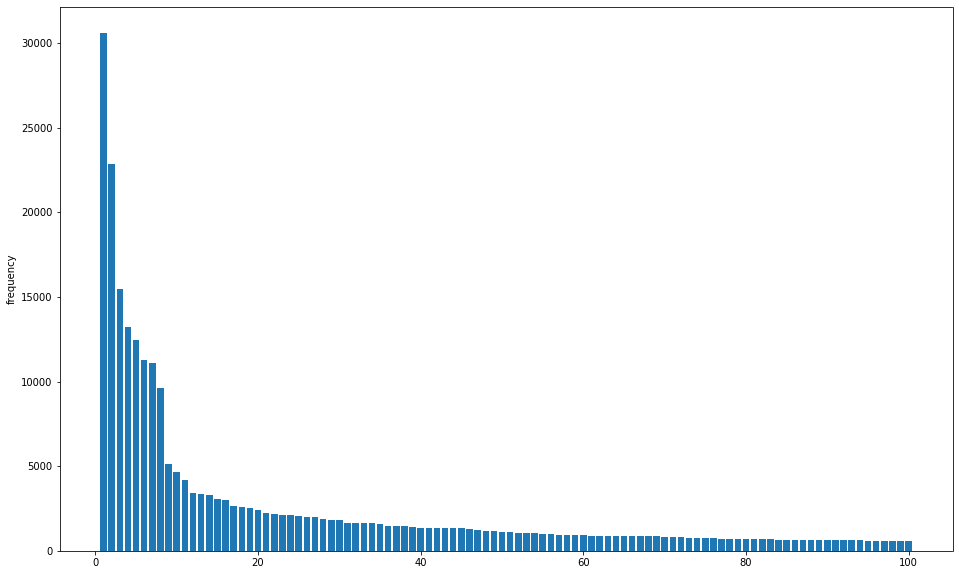

In [10]:
frequency=dict(Counter(lista_palabras).most_common()[0:100])
x=list(frequency.values())
plt.figure(figsize=(16,10))
plt.bar(range(1,101),x)
plt.ylabel('frequency')

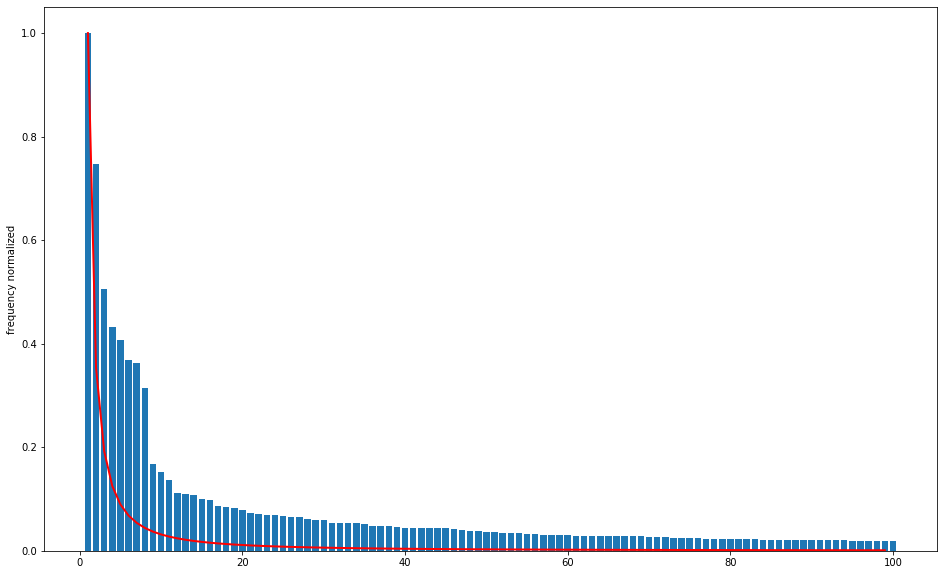

In [148]:
frequency=dict(Counter(lista_palabras).most_common()[0:100])
x=list(frequency.values())
myint=x[0]
x[:]=[z/myint for z in x]
plt.figure(figsize=(16,10))
plt.bar(range(1,101),x)
plt.ylabel('frequency normalized')

#Calculate zipf and plot the data
a = 1.5 #  distribution parameter
#count, bins, ignored = plt.hist(s[s<50], 50, normed=True)
x = np.arange(1., 100.)
y = x**(-a) / special.zetac(a)
plt.plot(x, y/max(y), linewidth=2, color='r')
plt.show()

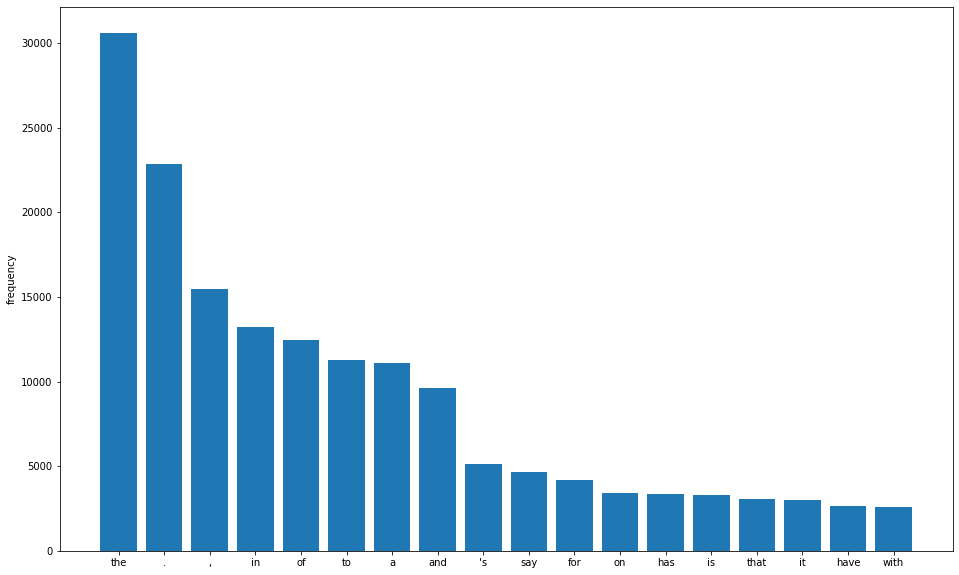

In [11]:
frequency=dict(Counter(lista_palabras).most_common()[0:18])
x=list(frequency.values())
plt.figure(figsize=(16,10))
plt.bar(list(frequency.keys()),x)
plt.ylabel('frequency')

plt.show()

###  c) Para representar cada posible *tag* y *lemma* de modo que la red pueda manejarlo, será necesario codificarlos a un número único (*indice*) ¿Cuántos *tags* y *lemmas* distintos existen?  Comente sobre el significado del *tag* para cada *lemma*. **Finalmente mida el largo máximo de entre todas las sentencias**.

In [5]:
n_labels = len(labels)
lab2idx = {t: i for i, t in enumerate(labels)}
dataY = [[lab2idx[ner] for ner in ner_tags ] for ner_tags in dataY_raw] #Converting tags to indexs
n_lemmas = len(lemmas)
lemma2idx = {w: i for i, w in enumerate(lemmas)} 
dataX = [[lemma2idx[lemma] for lemma in sentence ] for sentence in dataX_raw] #Converting text to indexs

In [159]:
dataset['tag'].value_counts()

O        888072
B-geo     37444
B-tim     20159
B-org     20134
I-per     17346
B-per     16975
I-org     16498
B-gpe     16368
I-geo      7396
I-tim      6291
B-art       434
B-eve       348
I-eve       297
I-art       280
I-gpe       229
B-nat       226
I-nat        76
Name: tag, dtype: int64

In [15]:
n_labels

17

In [16]:
n_lemmas 

12449

Hay 12449 lemmas y 17 tipos distinto de tags.

In [6]:
max(list_len_text)

70

La sentencia mas larga contiene 70 lemmas.

### d) Debido a la distinta extensión de textos se deberá **realizar *padding* para estandarizar el largo**, considere algun carácter especial **no presente en el vocabulario** para codificar el espacio en blanco en ambos (entrada y salida), por ejemplo si el largo máximo es de 4 y se tiene la sentencia "the rocket" codificada como [32,4] será necesario agregar un *lemma* que codificado significará el fin de la sentencia "the rocket *ENDPAD ENDPAD*" que codificado quedará como [32,4,*N, N*]. Decida, respecto al cómo funciona una red recurrente y su *memoria*, sobre qué le parece más conveniente al momento de rellenar con un valor especial ¿Al principio o al final de la sentencia? Comente

In [6]:
max_input_lenght=70;
lemma2idx["f"] = n_lemmas #add fullfill lemma and tag to the dictionary
lab2idx["n"] = n_labels
n_labels +=1
n_lemmas +=1
from keras.preprocessing import sequence
X = sequence.pad_sequences(dataX, maxlen=max_input_lenght,padding='post',value=lemma2idx["f"])
y = sequence.pad_sequences(dataY, maxlen=max_input_lenght,padding='post',value=lab2idx["n"])
del dataY[:],dataX[:]

Using TensorFlow backend.


In [14]:
a=len(X)
b=len(X[0])
for i in range(a):
    if len(X[i])!=b:
        print('error')    
c=len(y)
d=len(y[0])
for i in range(a):
    if len(y[i])!=b:
        print('error')            

Efectivamente se lograron rellenar las listas de palabras y tags codificadas para que todas tengan el mismo largo (70).

In [19]:
min(list_len_text)

1

Decidimos rellenar con un valor especial al final de la sentencia porque de este modo le damos mas importancia a las palabras que estan al inicio de una oración que a las del final, puesto que las del final se veran afectadas por los posibles ceros que estaran en esa misma posición pero en otra sentencia ya que como ya vimos los largos son variables. Creemos que el inicio de la oración es mas relevante para el significado de una oración que el final de este, esta conclusión puede variar según el idioma de las sentencias.


### e) Para poder generar una representación adecuada sobre los datos de entrada que permita realizar operaciones lineales, deberá generar una representación a un vector denso. Para ésto se utilizará la arquitectura de autoencoder **Word2Vec** [[2]](#refs) sobre textos *raws* de largo variable, en donde el *encoder* codifica una palabra categórica (*target*) a un vector denso de dimensionalidad $d$ mientras que el *decoder* genera palabras en el contexto (*context*) de la palabra *target* (en una vecindad alrededor). La idea detrás es que palabras similares sean proyectadas a una región cercana en el espacio de *embedding* ¿Cuál es la importancia del parámetro min_count? ¿Cuántos *lemmas* ve Word2Vec?

In [7]:
from gensim.models import Word2Vec

EMBEDDING_DIM = 32 
window_size = 5 #“Window size” o ventana es el parámetro que determina el número de palabras de cada contexto.
                #is the maximum distance between the current and predicted word within a sentence.
nb_epoch = 5 #number of iterations (epochs) over the corpus
batch_size = 6000 #target size (in words) for batches of examples passed to worker threads 
min_count = 3 #ignore all words with total frequency lower than this.

model = Word2Vec(dataX_raw,size=EMBEDDING_DIM,window=window_size,batch_words=batch_size,iter=nb_epoch,
                 min_count=min_count, negative=5,sg=1) #sg=1 mean skip-gram

embeddings_index = {vocab_word: model.wv[vocab_word] for vocab_word in model.wv.vocab}

len(embeddings_index.keys())

C:\Users\Fernanda\Anaconda3\envs\py35\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


6957

El parámetro min_count determina la frecuencia límite que debe ser considerada para el modelo Word2Vec.  
El modelo ve 6957 palabras que corresponden a las palabras con una frecuencia mayor o igual a 3 (valor asignador para el parámetro min_count)  

In [20]:
Counter(lista_palabras).most_common()[6956]

('richardson', 3)

In [19]:
Counter(lista_palabras).most_common()[6957]

('brighton', 2)

### Genere una matriz de *embeddings* que se utilizarán como capa neuronal.

In [8]:
embedding_matrix = np.zeros((n_lemmas, EMBEDDING_DIM))
for word, i in lemma2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: #if word does not has embedding
        embedding_matrix[i] = embedding_vector

In [22]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.1015465 , -0.49151638,  0.08234049, ..., -0.10536448,
         0.34058073,  0.0554193 ],
       [ 0.15245332, -0.28893521, -0.15803733, ..., -0.407974  ,
        -0.03574137, -0.09787148],
       ...,
       [-0.38047859, -0.58991289,  0.88114774, ..., -0.62531745,
         0.40532103, -0.06130425],
       [ 0.17389463, -0.38119942,  0.13918138, ..., -0.0867018 ,
         0.33539271, -0.07945963],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

### Luego, para poder realizar una clasificación sobre los datos en la salida será necesario representarlos *one hot vectors*, esto resultará en un arreglo tridimensional.

In [9]:
from keras.utils import to_categorical
y = np.asarray([to_categorical(i, num_classes=n_labels) for i in y])

In [24]:
y

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0.

### f) Luego de esto cree los conjuntos de entrenamiento y de prueba con el código a continuación **¿Cuáles son las dimensiones de entrada y salida de cada conjunto?** Comente

In [25]:
import sklearn as sk

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=22)
y_train.shape

(16030, 70, 18)

In [31]:
X_train.shape

(16030, 70)

El vector X de entrada tiene 16030 ejemplos cada uno de largo 70 mientras que el vector Y tiene la misma cantidad solo que en cada posición sobre los 70 corresponde a un vector de largo 18 que corrresponde a los 17 tags iniciales más el agregado al final. 

### g) Defina una red neuronal recurrente *many to many* con compuertas LSTM para aprender a *tagear* la entidad en el texto. Esta red debe procesar la secuencia de *lemmas* rellenados (o sin rellenar) y entregar el *tag* a cada uno de los *lemmas*, por lo que la salida de la red es una por cada instante de tiempo que se necesita entregar un *output*. La primera capa de la red a construir debe tener los vectores de *embedding* encontrados por **Word2Vec**. **Comente sobre los cambios que sufre un dato al ingresar a la red y la cantidad de parámetros de la red**. Entrene y luego evalúe su desempeño sobre ambos conjuntos. 

In [20]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout,TimeDistributed, GRU, Bidirectional
from sklearn.metrics import f1_score

In [32]:

model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=False, weights = [embedding_matrix]))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(n_labels, activation='softmax')))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 32)            398400    
_________________________________________________________________
lstm_1 (LSTM)                (None, 70, 100)           53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 70, 100)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 70, 18)            1818      
Total params: 453,418
Trainable params: 55,018
Non-trainable params: 398,400
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 16030 samples, vali

Hay un total de 453.418 parametros de los cuales sólo 55.018 están siendo entrenados, esto hace que la red tenga menos flexibilidad para adapatarse a los cambios que provee un ejemplo.  
Sobre los cambios que sufre un dato al pasar por la red notamos que al entrar la capa de embedding a cada vector de entrada le agrega un arreglo de tamaño 32, es decir lo mete en un espacio mas denso. Luego entra en la capa de lstm que transforma cada arreglo de tamaño 32 en uno de 100, es decir aumenta aún la dimensión y luego entra en una capa de dropout que no cambia la dimensionalidad sino que fija valores arbitrarios a cero. Finalmente la capa de time distributed aplana la secuencia para crear secuencias de tiempo mezcladas y esta tenga coherencia con el output que deseamos.

### Para evaluar su modelo utilice una métrica adecuada para el desbalance presente entre las clases como identificó en el punto b). Tenga presente en este punto el **no evaluar** la clase/símbolo que añadió para realizar *padding* a los *tag*.  
*Hint: podría "truncar" la salida predicha hasta el largo real de esa sentencia*.

In [81]:

dataY_pred = model.predict_classes(X_test,verbose=0) #process... to remove prediction on "endtagger" symbol


In [17]:
matriz_pos=np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]);
largo1=len(y_test);
largo2=len(y_test[0]);
lista1=[]
lista2=[]
for i in range(largo1):
    for j in range(largo2):
        lista2.append(int(np.dot(y_test[i][j],matriz_pos)))
    lista1.append(lista2)
    lista2=[]
largo=len(lista1)
D_original=list(np.zeros(largo))
for i in range(largo):
    D_original[i]=[w for w in lista1[i] if w!=17]

In [18]:
largo=len(dataY_pred)
D=list(np.zeros(largo))
for i in range(largo):
    D[i]=dataY_pred[i][0:len(D_original[i])]

In [90]:
f1_score_bydata = [f1_score(true, pred ,average='macro') for true,pred in zip(D_original,D) ]
print("F1 score on test: ", np.mean(f1_score_bydata) )

F1 score on test:  0.675542072702955


Precision mide la probabilidad de que la muestra haya sido clasificada como positiva cuando en realidad es positiva mientras que el recall mide la proporción entre valores que son negativos y fueron clasificados como positivos entre todas las muestras que fueron clasificadas o son negativas.  
F1 toma en consideración tanto los falsos positivos como los falsos negativos que es muy útil en este tipo de problemas pues los tags asignados no estan balanceados y esto quiere decir que por ejemplo si consideramos solo el recall daría un valor muy pequeño puesto que hay un tag que se repite bastante y por ende es muy probable que la red prediga muchos con este tag, luego el denominador de la formula de precisión se vuelve mas grande y por ende el resultado final mas pequeño. Mientras que la precisión no se ve tan afectado por este tipo de fenonemos pues estas muestras descritas se estan contando tanto en el numerados como en el denominador.     
Dicho esto, el F1 arrojado por el modelo nos dice que el modelo no es tan bueno como puesto que sabemos hay muchos valores que clasificara como el tag mas repetido y que realmente lo son, es por esto que se debe ajustarse el modelo.  


### h) Varíe con seguir entrenando la capa de embedding seteada al definir la arquitectura, ésto es cambiar a *trainable=True*, compare el desempeño y el número de parámetros (entrenables) con lo anterior. Comente

In [91]:
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=True, weights = [embedding_matrix]))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(n_labels, activation='softmax')))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 70, 32)            398400    
_________________________________________________________________
lstm_2 (LSTM)                (None, 70, 100)           53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 70, 100)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 70, 18)            1818      
Total params: 453,418
Trainable params: 453,418
Non-trainable params: 0
_________________________________________________________________
Train on 16030 samples, validate on 6871 samples
Epoch 1/15
16030/16030 [==============================] - 17s 1ms/step - loss: 0.6012 - val_loss: 0.2428
Epoch 2/15
16030/16030 [==============================] - 16s 1ms/step - loss: 0.1958 - val_loss: 0.1461
Epoch 3/1

In [92]:
dataY_pred = model.predict_classes(X_test,verbose=0) #process... to remove prediction on "endtagger" symbol
largo=len(dataY_pred)
D1=list(np.zeros(largo))
for i in range(largo):
    D1[i]=dataY_pred[i][0:len(D_original[i])]
    
    
f1_score_bydata = [f1_score(true, pred ,average='macro') for true,pred in zip(D_original,D1) ]
print("F1 score en test con trainable True : ", np.mean(f1_score_bydata) )    

F1 score en test con trainable True :  0.8318508027686168


A diferencia de el modelo anterior, aca todos los parametros son entrenables lo que da mayor flexibilidad al modelo para adaptarse a los diferentes input que entran, aprender de esto e incorporarlo para otros input. Como es de esperarse el F1 score de este modelo es mejor que el del anterior puesto que al ser mas flexible permite que menos de los valores que fueron clasificados erroneamente como con otro tag (por el mas repetido generalmente) puedan finalmente ser clasificados como el que corresponde.

### i) Experimente con cambiar la *gate* de recurrencia a una con menos parámetros pero que mantiene la capacidad de memoria de la LSTM, ésta es la compuerta GRU. Comente sobre los resultados esperados y observados.

In [93]:


model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=False, weights = [embedding_matrix]))
model.add(GRU(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(n_labels, activation='softmax')))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 70, 32)            398400    
_________________________________________________________________
gru_1 (GRU)                  (None, 70, 100)           39900     
_________________________________________________________________
dropout_3 (Dropout)          (None, 70, 100)           0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 70, 18)            1818      
Total params: 440,118
Trainable params: 41,718
Non-trainable params: 398,400
_________________________________________________________________
Train on 16030 samples, validate on 6871 samples
Epoch 1/15
16030/16030 [==============================] - 15s 935us/step - loss: 0.7198 - val_loss: 0.2335
Epoch 2/15
16030/16030 [==============================] - 14s 876us/step - loss: 0.2082 - val_loss: 0.1791


In [94]:
dataY_pred = model.predict_classes(X_test,verbose=0) #process... to remove prediction on "endtagger" symbol
largo=len(dataY_pred)
D2=list(np.zeros(largo))
for i in range(largo):
    D2[i]=dataY_pred[i][0:len(D_original[i])]
    
    
f1_score_bydata = [f1_score(true, pred ,average='macro') for true,pred in zip(D_original,D2) ]
print("F1 score en test con GRU : ", np.mean(f1_score_bydata) )  

F1 score en test con GRU :  0.6944534899623724


Los resultados obtenidos son peores que el anterior lo cual tiene mucho sentido con el cambio que se hizo. Disminuir la cantidad de parametros entrenables es una mala decisión puesto que dada la cantidad de clases que existen y el poco equilibrio entre ellas hace que el modelo prediga una gran cantidad de tags que pertenecen a las clases menos numerosas como aquel tag mas frecuente. Más aún GRU se dice que es mejor computacionalmente que en teoría recuerda menos que una LSTM, luego como capacidad de memoria es menor o igual, por el efecto explicado anteriormente, el modelo predecirá muchos como el mas repetido.

### j) Algunos autores señalan la importante dependencia que existe en texto, no solo con las palabras anteriores, sino que con las que siguen. Mejore la red utilizando una red neuronal recurrente Bidireccional, es decir, con recurrencia en ambas direcciones sobre la secuencia de lemmas. Comente cuál debiera ser la forma correcta de usar el parámetro merge_mode (concatenar, multiplicar, sumar o promediar) para este caso. Además comente las transformaciones que sufre el patrón de entrada al pasar por las capas. ¿Mejora o empeora el desempeño? Analice.


In [98]:


model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=False, weights = [embedding_matrix]))
gate_layer = GRU(units=100,return_sequences=True)
model.add(Bidirectional(gate_layer, merge_mode='concat'))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(n_labels, activation='softmax')))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 70, 32)            398400    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 70, 200)           79800     
_________________________________________________________________
dropout_4 (Dropout)          (None, 70, 200)           0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 70, 18)            3618      
Total params: 481,818
Trainable params: 83,418
Non-trainable params: 398,400
_________________________________________________________________
Train on 16030 samples, validate on 6871 samples
Epoch 1/15
16030/16030 [==============================] - 26s 2ms/step - loss: 0.6089 - val_loss: 0.1839
Epoch 2/15
16030/16030 [==============================] - 25s 2ms/step - loss: 0.1593 - val_loss: 0.1373
Epoc

In [99]:
dataY_pred = model.predict_classes(X_test,verbose=0) #process... to remove prediction on "endtagger" symbol
largo=len(dataY_pred)
D3=list(np.zeros(largo))
for i in range(largo):
    D3[i]=dataY_pred[i][0:len(D_original[i])]
    
    
f1_score_bydata = [f1_score(true, pred ,average='macro') for true,pred in zip(D_original,D3) ]
print("F1 score en test con Bidirectional: ", np.mean(f1_score_bydata) ) 

F1 score en test con Bidirectional:  0.7362942377760479


El merge mode es el modo en el cual los output del forward pass y el backward pass son combinados en una red neuronal. Puede tomar elegirse como {'sum', 'mul', 'concat', 'ave', None}. Se eligió el merge mode como 'concat' porque creemos que este modo utiliza mejor la información obtenida en el forward y backward pass (puede comparar) mientras que en los otros modos se pierde información al sumar o multiplicar.(Si no se elige, por default no se hace ninguno y entrega una lista)   
Sobre las transformaciones que sufre el patrón de entrada al pasar por las capas notamos que al entrar en la primera capa de embedding aumenta la dimensionalidad a cada una de las 70 posiciónes del vector en un nuevo vector de 32 dimensiones, luego la capa bidireccional transforma este arreglo de tamaño 32 en uno de tamaño 200 puesto que el parametro de la GRU esta en 100 unidades ( 100 para un lado y 100 para el otro). Luego entra en la capa de dropout que hace que el 20% de los valores sean cero, es decir no cambia la dimensión y finalmente esta la capa de dropout que reconfigura la forma del vector para poder ser comparado con el ouput de salida. 

Se obtuvo un resultado un poco mejor que el modelo anterior ahora que se utilizo una capa bidireccional. Esta capa ayuda a incluir la información sobre el input y su valor de salida lo que es es muy útil para este tipo de problemas poco balanceado ya explicado en los modelos anteriores. Sin embargo, para que esta información sea útilizada por el modelo es necesario aumentar la cantidad de parametros entrenables.

### k) En base a lo experimentado, **mejore el desempeño de las redes encontradas**, ya sea utilizando y/o combinando las distintas variaciones que se hicieron en los distintos ítemes, como bien alguna mejora en el pre-proceso de los datos (largo de secuencia, el tipo de *padding* o alguna otra), agregar mayor profundidad, variar el número de unidades/neuronas, utilizando otra *gate* de recurrencia (en https://keras.io/layers/recurrent/), cambiar los vectores de *embedding* por unos entrenados en otros dataset más grandes (https://nlp.stanford.edu/projects/glove/), entre otros.

In [100]:
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=True, weights = [embedding_matrix]))
gate_layer = GRU(units=100,return_sequences=True)
model.add(Bidirectional(gate_layer, merge_mode='concat'))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(n_labels, activation='softmax')))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=128)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 70, 32)            398400    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 70, 200)           79800     
_________________________________________________________________
dropout_5 (Dropout)          (None, 70, 200)           0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 70, 18)            3618      
Total params: 481,818
Trainable params: 481,818
Non-trainable params: 0
_________________________________________________________________
Train on 16030 samples, validate on 6871 samples
Epoch 1/20
16030/16030 [==============================] - 29s 2ms/step - loss: 0.6044 - val_loss: 0.1579
Epoch 2/20
16030/16030 [==============================] - 28s 2ms/step - loss: 0.1202 - val_loss: 0.0933
Epoch 3/2

In [101]:
dataY_pred = model.predict_classes(X_test,verbose=0) #process... to remove prediction on "endtagger" symbol
largo=len(dataY_pred)
D4=list(np.zeros(largo))
for i in range(largo):
    D4[i]=dataY_pred[i][0:len(D_original[i])]
    
    
f1_score_bydata = [f1_score(true, pred ,average='macro') for true,pred in zip(D_original,D4) ]
print("F1 score en test con Bidirectional y trainable: ", np.mean(f1_score_bydata) ) 

F1 score en test con Bidirectional y trainable:  0.8701776954811137


Efectivamente haciendo el cambio sugerido en el inciso anterior se obtuvo un mejor resultado y creemos que la razon se debe netamente la cantidad de parametros entrenables.

In [107]:
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=True, weights = [embedding_matrix]))
gate_layer = GRU(units=100,return_sequences=True)
model.add(Bidirectional(gate_layer, merge_mode='sum'))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(n_labels, activation='softmax')))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=128)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 70, 32)            398400    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 70, 100)           79800     
_________________________________________________________________
dropout_8 (Dropout)          (None, 70, 100)           0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 70, 18)            1818      
Total params: 480,018
Trainable params: 480,018
Non-trainable params: 0
_________________________________________________________________
Train on 16030 samples, validate on 6871 samples
Epoch 1/20
16030/16030 [==============================] - 29s 2ms/step - loss: 0.5813 - val_loss: 0.1572
Epoch 2/20
16030/16030 [==============================] - 29s 2ms/step - loss: 0.1222 - val_loss: 0.0953
Epoch 3/2

In [106]:
dataY_pred = model.predict_classes(X_test,verbose=0) #process... to remove prediction on "endtagger" symbol
largo=len(dataY_pred)
D5=list(np.zeros(largo))
for i in range(largo):
    D5[i]=dataY_pred[i][0:len(D_original[i])]
    
    
f1_score_bydata = [f1_score(true, pred ,average='macro') for true,pred in zip(D_original,D5) ]
print("F1 score en test con Bidirectional,trainable y sum: ", np.mean(f1_score_bydata) ) 

F1 score en test con Bidirectional,trainable y sum:  0.8689728407817965


Se hizo el mismo modelo pero con distinto merge mode para comparar resultados. Se obtuvo mejor resultados con el parametro merge mode sum, lo cual no se esperaba dado que no provee tanta información como concat. Es posible que esta mejora se deba a que sum acentué mejor ciertos valores que no se lograban apreciar en 1 una sola secuencia y si al sumarlas.

La mejor es con Bidirectional, trainable y sum en 20 epochs

In [104]:
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=True, weights = [embedding_matrix]))
gate_layer = GRU(units=100,return_sequences=True)
model.add(Bidirectional(gate_layer, merge_mode='mul'))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(n_labels, activation='softmax')))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=128)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 70, 32)            398400    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 70, 100)           79800     
_________________________________________________________________
dropout_7 (Dropout)          (None, 70, 100)           0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 70, 18)            1818      
Total params: 480,018
Trainable params: 480,018
Non-trainable params: 0
_________________________________________________________________
Train on 16030 samples, validate on 6871 samples
Epoch 1/20
16030/16030 [==============================] - 28s 2ms/step - loss: 0.9090 - val_loss: 0.2321
Epoch 2/20
16030/16030 [==============================] - 30s 2ms/step - loss: 0.1730 - val_loss: 0.1235
Epoch 3/2

In [108]:
dataY_pred = model.predict_classes(X_test,verbose=0) #process... to remove prediction on "endtagger" symbol
largo=len(dataY_pred)
D6=list(np.zeros(largo))
for i in range(largo):
    D6[i]=dataY_pred[i][0:len(D_original[i])]
    
    
f1_score_bydata = [f1_score(true, pred ,average='macro') for true,pred in zip(D_original,D6) ]
print("F1 score en test con Bidirectional,trainable y mul: ", np.mean(f1_score_bydata) ) 

F1 score en test con Bidirectional,trainable y mul:  0.8827482544844898


Se encontró un mejor resultado con el parametro merge mode en mul en comparación a los anteriores. Siguiendo la lógica anterior para sobre el parametro sum, es posible que el modo mul logré destacar aún más ciertos valores que no se logran ver y esto hace que le de mayor probabilidad de ser elegidos a tags que no son tan frecuentes. Es decir, el parametro concat podría ser útil para problemas que requieran mayor "memoria" mientras que mul podría ser mejor cuando existen clases desbalanceadas.

### l) Utilice la red con mejor desempeño encontrada, idealmente la encontrada en (j), y **muestre las predicciones** del *NER tager*, sobre algún ejemplo de pruebas, comente.  

In [15]:
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=True, weights = [embedding_matrix]))
gate_layer = GRU(units=100,return_sequences=True)
model.add(Bidirectional(gate_layer, merge_mode='mul'))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(n_labels, activation='softmax')))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=128)



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 70, 32)            398400    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 70, 100)           79800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 70, 100)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 70, 18)            1818      
Total params: 480,018
Trainable params: 480,018
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 16030 samples, validate on 6871 samples
Epoch 1/20
16030/16030 [==============================] 

In [21]:
dataY_pred = model.predict_classes(X_test,verbose=0) #process... to remove prediction on "endtagger" symbol
largo=len(dataY_pred)
D6=list(np.zeros(largo))
for i in range(largo):
    D6[i]=dataY_pred[i][0:len(D_original[i])]
    
    
f1_score_bydata = [f1_score(true, pred ,average='macro') for true,pred in zip(D_original,D6) ]
print("F1 score en test con Bidirectional,trainable y mul: ", np.mean(f1_score_bydata) ) 

C:\Users\Fernanda\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Fernanda\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


F1 score en test con Bidirectional,trainable y mul:  0.868293386778767


In [23]:
p = model.predict(np.array([X_test[i]]))

In [24]:
p = np.argmax(p, axis=-1)

In [84]:
p[0]

array([ 6,  6,  6,  6,  6,  6,  6,  6, 15,  6,  6,  6,  6, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17], dtype=int64)

In [97]:
X_test

array([[12124,  8846,  1406, ..., 12449, 12449, 12449],
       [ 8896, 10823,  1206, ..., 12449, 12449, 12449],
       [   70,    57, 11489, ..., 12449, 12449, 12449],
       ...,
       [12141,  3075,  2764, ..., 12449, 12449, 12449],
       [11297,  6291,  9215, ..., 12449, 12449, 12449],
       [ 5552,  5236,  8896, ..., 12449, 12449, 12449]])

In [104]:
n=len(X_test)

In [88]:
X_test[0]


array([12124,  8846,  1406, 11085,   103,  2706, 12155, 11184,   938,
        8846,  5466,  7184,  4247,  8278,  3297, 12449, 12449, 12449,
       12449, 12449, 12449, 12449, 12449, 12449, 12449, 12449, 12449,
       12449, 12449, 12449, 12449, 12449, 12449, 12449, 12449, 12449,
       12449, 12449, 12449, 12449, 12449, 12449, 12449, 12449, 12449,
       12449, 12449, 12449, 12449, 12449, 12449, 12449, 12449, 12449,
       12449, 12449, 12449, 12449, 12449, 12449, 12449, 12449, 12449,
       12449, 12449, 12449, 12449, 12449, 12449, 12449])

In [89]:
X_test[0][0]

12124

In [53]:
lista_palabras[17]
lista_palabras[12449]


'for'

In [91]:
p = model.predict(np.array([X_test[i]])) #original
p = np.argmax(p, axis=-1)
print("{:15}: {}".format("Lemma", "Pred"))
for w,pred in zip(X_test[i],p[0]):
    print("{:15}: {}".format(lemmas[w],labels[pred]))

IndexError: index 499999 is out of bounds for axis 0 with size 6871

<a id="refs"></a>
## Referencias
[1] https://es.wikipedia.org/wiki/Ley_de_Zipf    
[2] Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). *Efficient estimation of word representations in vector space*. arXiv preprint arXiv:1301.3781.    
[3] Cho, K., Van Merriënboer, B., Bahdanau, D., & Bengio, Y. (2014). *On the properties of neural machine translation: Encoder-decoder approaches*. arXiv preprint arXiv:1409.1259.  
[4] Pal, N. R., & Pal, S. K. (1993). *A review on image segmentation techniques*. Pattern recognition, 26(9), 1277-1294.  
[5] Badrinarayanan, V., Kendall, A., & Cipolla, R. (2017). *Segnet: A deep convolutional encoder-decoder architecture for image segmentation*. IEEE transactions on pattern analysis and machine intelligence, 39(12), 2481-2495.  
[6] Papineni, K., Roukos, S., Ward, T., & Zhu, W. J. (2002, July). *BLEU: a method for automatic evaluation of machine translation*. In Proceedings of the 40th annual meeting on association for computational linguistics (pp. 311-318). Association for Computational Linguistics.  
[7] Kingma, D. P., & Welling, M. (2013). *Auto-encoding variational bayes*. arXiv preprint arXiv:1312.6114.  
[8] https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence     
[9] Dumoulin, V., & Visin, F. (2016). *A guide to convolution arithmetic for deep learning*. arXiv preprint arXiv:1603.07285.  also: https://github.com/vdumoulin/conv_arithmetic  
[10] Jang, E., Gu, S., & Poole, B. (2016). *Categorical reparameterization with gumbel-softmax*. arXiv preprint arXiv:1611.01144.  